In [48]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
from pydantic import BaseModel, Field
from typing import TypedDict, Annotated, Literal
from IPython.display import Image
import operator
from dotenv import load_dotenv
import os

load_dotenv()

content_model = ChatOpenAI(model=os.getenv("oldgpt_model"))
eval_model = ChatOpenAI(model=os.getenv("strgpt_model"))
optimize_model = ChatOpenAI(model=os.getenv("gpt_model"))

In [49]:
class post_evalSchema(BaseModel):
    evaluation: Literal['approved', 'need_improvement'] = Field(description='Final evaluation')
    feedback: str = Field(description='feedback for the post')
str_eval_model = eval_model.with_structured_output(post_evalSchema)

In [50]:
class PostState(TypedDict):
    topic: str
    post: str
    evaluation: Literal['positive','negative']
    feedback: str
    iter: int
    max_iter: int

In [64]:
def generate_post(state: PostState):
    prompt = [SystemMessage(content="You are an experianced CNN Engineer"),
              HumanMessage(f'Create a LinkedIN post for the topic of\n{state['topic']}\nThe post should not be greater than 250 characters\nThis iteration is {state['iter']+1}')]
    post_generated = content_model.invoke(prompt).content

    return {'post': post_generated}

def evaluvate_post(state: PostState):
    prompt = [SystemMessage(content="you are a moderator who review post on LinkedIN community"),
              HumanMessage(content=f"""evaluvate post: -\n{state['post']}\n
                           You have to review this technical post make sure the post is technical and simple to understand. response only in \n
                           evaluation: 'approved' and 'need_improvement'\n
                           feedback: one paragraph explaining strength and weaknesses""")]
    
    str_eval = str_eval_model.invoke(prompt)
    return {'evaluation': str_eval.evaluation, 'feedback': str_eval.feedback}

def optimize_post(state:PostState):
    prompt = [SystemMessage(content="you optimize post on a given feedback"),
              HumanMessage(content=f"""Improve post: -\n{state['post']}\n
                           of the following feedback: - {state['feedback']}""")]
    post_generated = optimize_model.invoke(prompt).content
    iter = state['iter']+1
    return {'post':post_generated,'iter':iter}

In [65]:
def route_eval(state: PostState):
    if state['evaluation'] == 'approved' or state['iter'] >= state['max_iter']:
        return 'approved'
    else:
        return 'need_improvement'

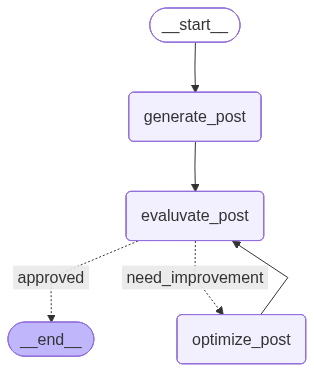

In [66]:
graph = StateGraph(PostState)

graph.add_node('generate_post',generate_post)
graph.add_node('evaluvate_post',evaluvate_post)
graph.add_node('optimize_post',optimize_post)

graph.add_edge(START, 'generate_post')
graph.add_edge('generate_post', 'evaluvate_post')
graph.add_conditional_edges('evaluvate_post', route_eval,{'approved':END,'need_improvement':'optimize_post'})
graph.add_edge('optimize_post','evaluvate_post')

workflow = graph.compile()
Image(workflow.get_graph().draw_mermaid_png())

In [67]:
topic = {'topic':'YOLO26', 'iter':1,'max_iter':5}
topic_output = workflow.invoke(topic)

In [68]:
topic_output

{'topic': 'YOLO26',
 'post': 'Excited to announce the release of YOLOv2.6 - the latest iteration of the popular object detection model! 🚀 #YOLO26 #AI #ComputerVision',
 'evaluation': 'approved',
 'feedback': "The post effectively communicates excitement about the release of YOLOv2.6, capturing attention with a clear and engaging announcement. The use of relevant hashtags helps to categorize the content within the AI and computer vision communities. However, the post could be improved by providing a brief overview of the key features or improvements in this version of the model, as this would enhance the technical understanding for readers who may not be familiar with YOLO's development history.",
 'iter': 1,
 'max_iter': 5}

In [69]:
topic = {'topic':'experiance of Indian Rail poor food service', 'iter':1,'max_iter':5}
topic_output = workflow.invoke(topic)

In [70]:
topic_output

{'topic': 'experiance of Indian Rail poor food service',
 'post': 'Reflecting on my recent experience with the food service on Indian Railways, I believe there is a pressing need for improvements to enhance passenger satisfaction. \n\nThe quality and timeliness of meal delivery, as well as the variety of options available, are crucial elements that can significantly impact the overall travel experience. For example, implementing a pre-order system could allow passengers to select their meal preferences in advance, ensuring freshness and reducing wait times. Furthermore, increasing the number of food vendors on board could provide travelers with a wider array of choices, catering to diverse dietary requirements.\n\nThe consequences of inadequate food service extend beyond mere inconvenience; they can lead to diminished passenger satisfaction and adversely affect the perception of Indian Railways as a whole. Addressing these issues not only enhances the travel experience but also fosters